In [3]:
import sys
sys.path.append("../")

import utils
from crbm import CRBM
import analysis_methods as am

from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import math
import subprocess as sp
import matplotlib.image as mpimg

In [1]:
# Directory of Stored CRBMs
mdir = "/mnt/D1/globus/cov_trained_crbms/nw/"
# Which crbms are we looking at
rounds = [f"r{i}_n2" for i in [9]]

# data keys
data_keys = [f"r{i}" for i in range(3, 13)]

#### Generate Weights

In [4]:
# generate weights in respective
# for rid, round in enumerate(rounds):
    # if rid > 0:
    #     break
checkp, version_dir = am.get_checkpoint_path(rounds[0], rbmdir=mdir)
tmp = CRBM.load_from_checkpoint(checkp)
utils.all_weights(tmp, name=version_dir +rounds[0])

../utils.py:827: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
/home/jonah/anaconda3/envs/utils/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (158400000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [6]:
def assign(x):
    if x < 5.04e-9:
        return "N" # low
    elif x < 2:
        return "L" # medium
    else:
        return "H" # High

# Stores all data in a dictionary ("data")
all_data = am.fetch_data(data_keys, dir="../../datasets/cov/sw/", assignment_function=assign, threads=12)

Process Time 0.5732998847961426
Process Time 0.40498995780944824
Process Time 1.789318323135376
Process Time 1.423123836517334
Process Time 1.9812660217285156
Process Time 0.6328654289245605
Process Time 0.19931507110595703
Process Time 0.5038330554962158
Process Time 0.2576172351837158
Process Time 0.4930548667907715


In [7]:
# Low count == 1, Med count < 10, High count >= 10
# calculate likelihoods from last round rbm only
checkp, v_dir = am.get_checkpoint_path("r9_n2", rbmdir=mdir)
r9_crbm = CRBM.load_from_checkpoint(checkp)

In [8]:
# this takes awhile, might be something I optimize further in the future
am.generate_likelihoods(data_keys[::2], r9_crbm, all_data, "crbm_r9_n2")

In [9]:
r9_likelihoods = am.get_likelihoods("./generated/crbm_r9_n2.json")

<Figure size 2200x4500 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

<Figure size 1100x4500 with 0 Axes>

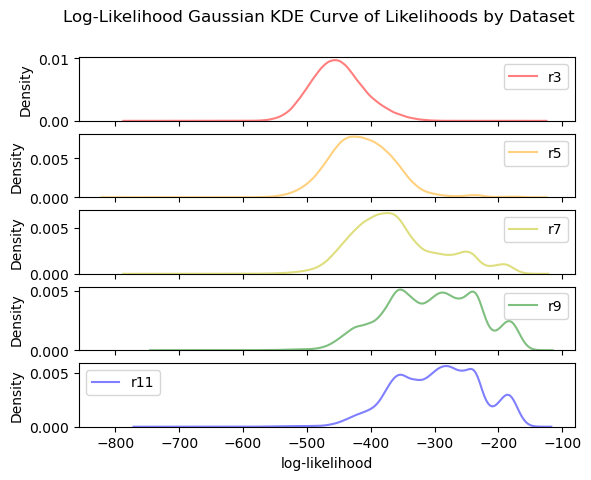

In [10]:
# Plot Likelihoods of Each batch of Data
am.plot_likelihoods(r9_likelihoods["likelihoods"], data_keys[::2], data_keys[::2], xlim=None, cdf=False)

In [11]:
print(r9_crbm.log_Z_AIS, r9_crbm.log_Z_AIS_std)

tensor(5845.6940) tensor(7.8696)


In [17]:
def shaded_kde_curve(ax, path, xmin, xmax, color):
    vertices = [ (x, y) for x, y in path.vertices if xmin < x < xmax]
    vertices.insert(0, (xmin, 0.))
    vertices.append((xmax, 0.))
    xfill, yfill = zip(*vertices)
    ax.fill(xfill, yfill, color)

def color_subplot(ax, color):
    for spine in ax.spines.values():
        spine.set_edgecolor(color)

def seqlogo_subplot(ax, path, type="info"):
    img = mpimg.imread(f"{path}.{type}.png")
    ax.imshow(img, interpolation="nearest")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])

# bounds listed in ascending order
def multi_peak_seq_log_fig(data, likelihoods, round, bounds, weight=False, title=None, xlim=None):
    data_subsets, seqlogo_paths = [], []
    for iid,  i in enumerate(bounds):
        sub = am.data_subset(data, likelihoods, round, i[0], i[1])
        seqlogo_paths.append(am.seq_logo(sub, f"peak{iid+1}_likeli_{round}", weight=weight, outdir="./generated/"))
        data_subsets.append(sub)

    peak_num = len(bounds)
    gs_kw = dict(width_ratios=[1 for x in range(peak_num)], height_ratios=[1, 1])
    fig, axd = plt.subplot_mosaic([['top' for x in range(peak_num)], [f'lower{x}' for x in range(peak_num)]],
                                  gridspec_kw=gs_kw, figsize=(15, 5), constrained_layout=False)

    axd["top"].set_xlim(*xlim)
    sns.kdeplot(likelihoods[round], ax=axd["top"])

    path = axd["top"].get_children()[0].get_path()

    for iid, i in enumerate(bounds):
         shaded_kde_curve(axd["top"], path, i[0], i[1], am.supported_colors[iid])

    axd["top"].set_xlabel("log-likelihood")
    for iid, i in enumerate(bounds):
        color_subplot(axd[f"lower{iid}"], am.supported_colors[iid])
        seqlogo_subplot(axd[f"lower{iid}"], seqlogo_paths[iid])

    if title is None:
        fig.suptitle(title)
    else:
        fig.suptitle(f"Composition of peaks across RBM Likelihood of Round{round}")

    plt.show()



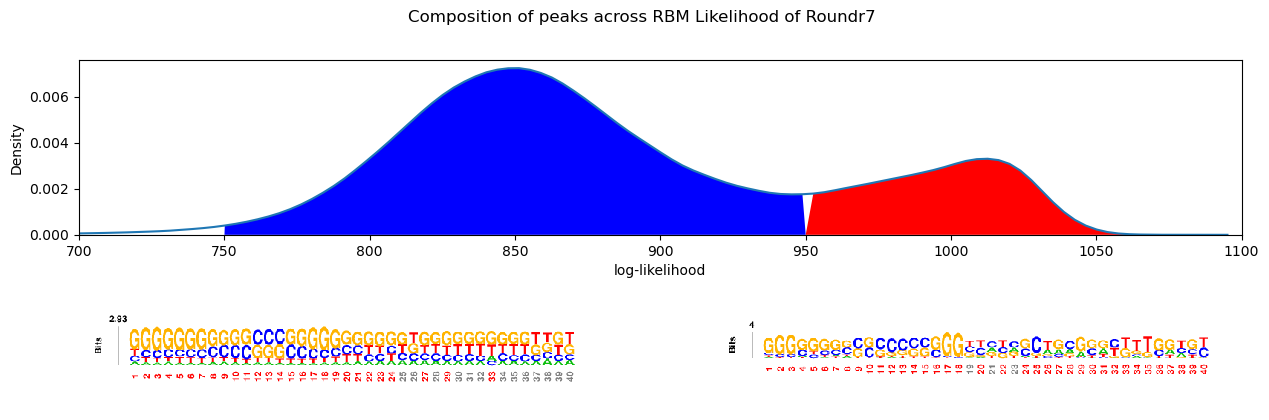

In [15]:
# multi_peak_seq_log_fig(all_data, r3_likelihoods["likelihoods"], "r3", [[1180, 1255], [1265, 1320]], weight=False, xlim=(1150, 1350))
am.multi_peak_seq_log_fig(all_data, r9_likelihoods["likelihoods"], "r7", [[750, 950], [950, 1100]], weight=False, title="r9 crbm of r7_data", xlim=(700, 1100))

In [16]:
exp_seqs = {
    "SP5": 'ACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT',
    "SP6": "CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT",
    "SP7": "CGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGGGT",
    "SP6C": 'CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTTGGT',
    "SP634":  "CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGG------",
    "SP634G": "CCCATGGTAGGTATTGGTTGGTAGGGATAGTGGG------",
    "SP634C": "CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGG------",
    "SP634A": "CCCATGGTAGGTATTGCATGGTAGGGATAGTGGG------",
    "SP630":  "---CATGGTAGGTATTGCATGGTAGGGATAGTG-------",
    "SP619":  "------------TATTGCATGGTAGGGATAG---------",
}

keys = exp_seqs.keys()
values = exp_seqs.values()
new_exp_seqs = {}
set_nuc = "A"
for i in keys:
    seq = exp_seqs[i]
    while "-" in seq:
        new_char = np.random.choice(["A", "C", "G", "T"])
        # new_char = set_nuc
        ind = seq.find("-")
        seq = seq[:ind] + new_char + seq[ind+1:]
    new_exp_seqs[i] = seq

rand_exp_seqs = new_exp_seqs
rand_exp_set = {'id':list(new_exp_seqs.keys()), 'sequence':list(new_exp_seqs.values())}
rand_exp_pd = pd.DataFrame(rand_exp_set)

exp_A_seqs = {
    "SP5":       'ACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT',
    "SP6":       "CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT",
    "SP7":       "CGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGGGT",
    "SP6C":      'CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTTGGT',
    "SP634":     "CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGAAAAAA",
    "SP634G":    "ACCATGGTAGGTATTGGTTGGTAGGGATAGTGGGAAAAAA",
    "SP634C":    "CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGAAAAAA",
    "SP634A":    "CCCATGGTAGGTATTGCATGGTAGGGATAGTGGGAAAAAA",
    "SP630":     "AACATGGTAGGTATTGCATGGTAGGGATAGTGAAAAAAAA",
    "SP619":     "AAAAAAAAAAATATTGCATGGTAGGGATAGAAAAAAAAAA",
    "r12_align": "AGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGTTGATT"
}
exp_A_set = {'id':list(exp_A_seqs.keys()), 'sequence':list(exp_A_seqs.values())}
exp_A_pd = pd.DataFrame(exp_A_set)


exp_set = {'id':list(exp_seqs.keys()), 'sequence':list(exp_seqs.values())}
exp_pd = pd.DataFrame(exp_set)

In [17]:
# exp_2_seqs, exp_2_likelis = r2_rbm.predict(exp_pd)
exp_3_A_seqs, exp_3_A_likelis = r9_crbm.predict(exp_A_pd)
exp_3_seqs, exp_3_likelis = r9_crbm.predict(exp_pd)
exp_3_rand_seqs, exp_3_rand_likelis = r9_crbm.predict(rand_exp_pd)

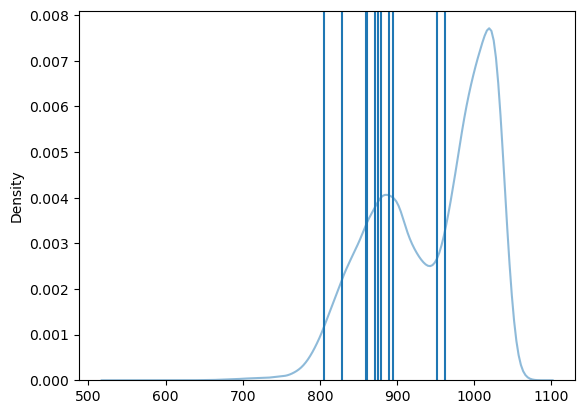

In [18]:
fig, axs = plt.subplots(1, 1)
y = sns.kdeplot(r9_likelihoods["likelihoods"]["r9"], shade=False, alpha=0.5, ax=axs)
for likeli in exp_3_A_likelis:
    plt.axvline(likeli)
plt.show()

In [19]:
labels = list(exp_seqs.keys())
for i in range(len(exp_seqs)):
    print(labels[i], exp_3_A_seqs[i], exp_3_A_likelis[i])

SP5 ACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT 889.7247683584574
SP6 CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT 895.0794275422677
SP7 CGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGGGT 962.8324603154042
SP6C CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTTGGT 859.565707304675
SP634 CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGAAAAAA 878.7686830244538
SP634G ACCATGGTAGGTATTGGTTGGTAGGGATAGTGGGAAAAAA 875.028395856636
SP634C CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGAAAAAA 829.2598934696471
SP634A CCCATGGTAGGTATTGCATGGTAGGGATAGTGGGAAAAAA 871.4874200427494
SP630 AACATGGTAGGTATTGCATGGTAGGGATAGTGAAAAAAAA 860.7980507298898
SP619 AAAAAAAAAAATATTGCATGGTAGGGATAGAAAAAAAAAA 805.7827262650326


##Clustering with the r3 CRBM

In [11]:
import torch

def clean_ax(ax):
    ax.axis("off")

def dataframe_to_input_crbm(dataframe, base_to_id, v_num, q, weights=False):
    seqs = dataframe["sequence"].tolist()
    oh_ten = torch.zeros((len(seqs), v_num, q), dtype=torch.long)
    for iid, seq in enumerate(seqs):
        for n, base in enumerate(seq):
            oh_ten[iid, n, base_to_id[base]] = 1
    if weights:
        weights = dataframe["copynum"].tolist()
        return oh_ten, weights
    else:
        return oh_ten


In [21]:
import analysis_methods_crbm as am_crbm

../utils.py:931: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
../utils.py:931: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
../utils.py:931: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
../utils.py:931: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)


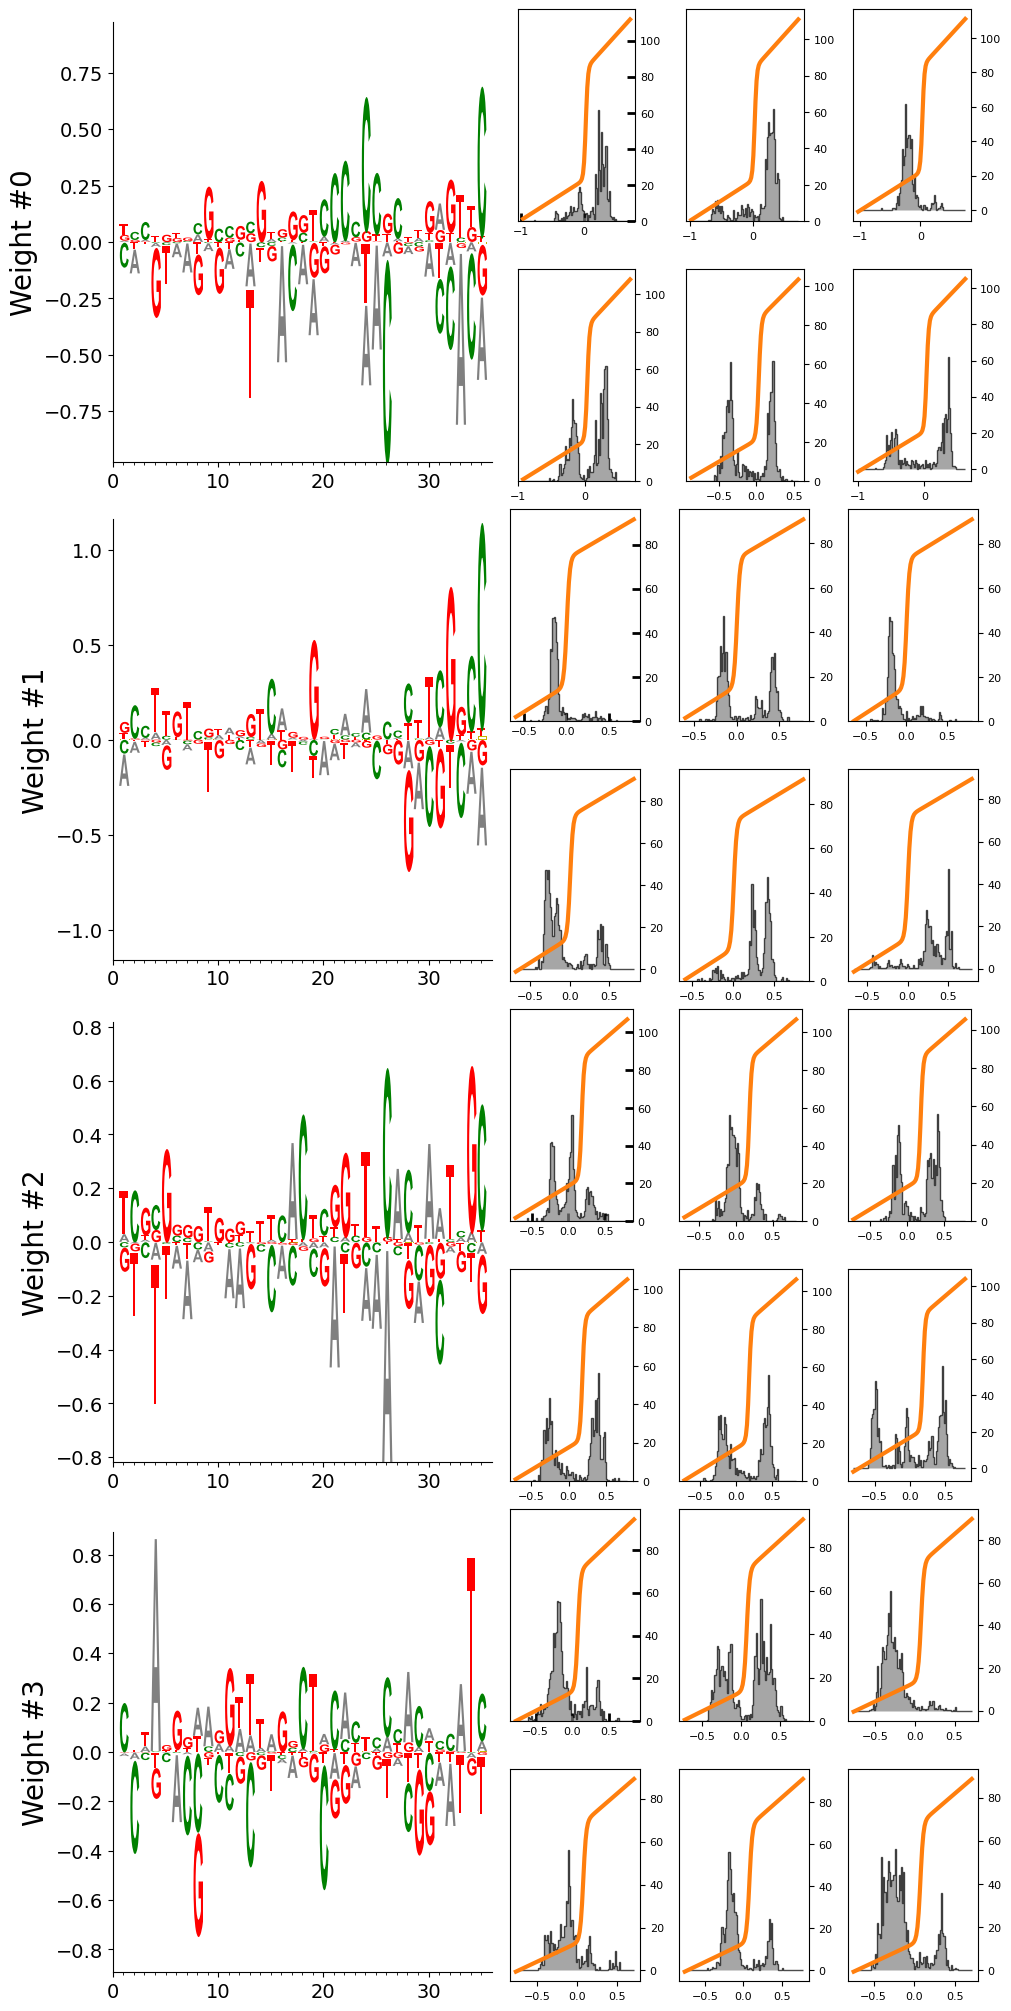

In [22]:
am_crbm.data_with_weights_plot(r9_crbm, all_data[all_data["round"] == "r9"], "hidden5", [0, 1, 2, 3], kdim="full", data="mean")

../utils.py:931: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
../utils.py:931: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
../utils.py:931: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)
../utils.py:931: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)


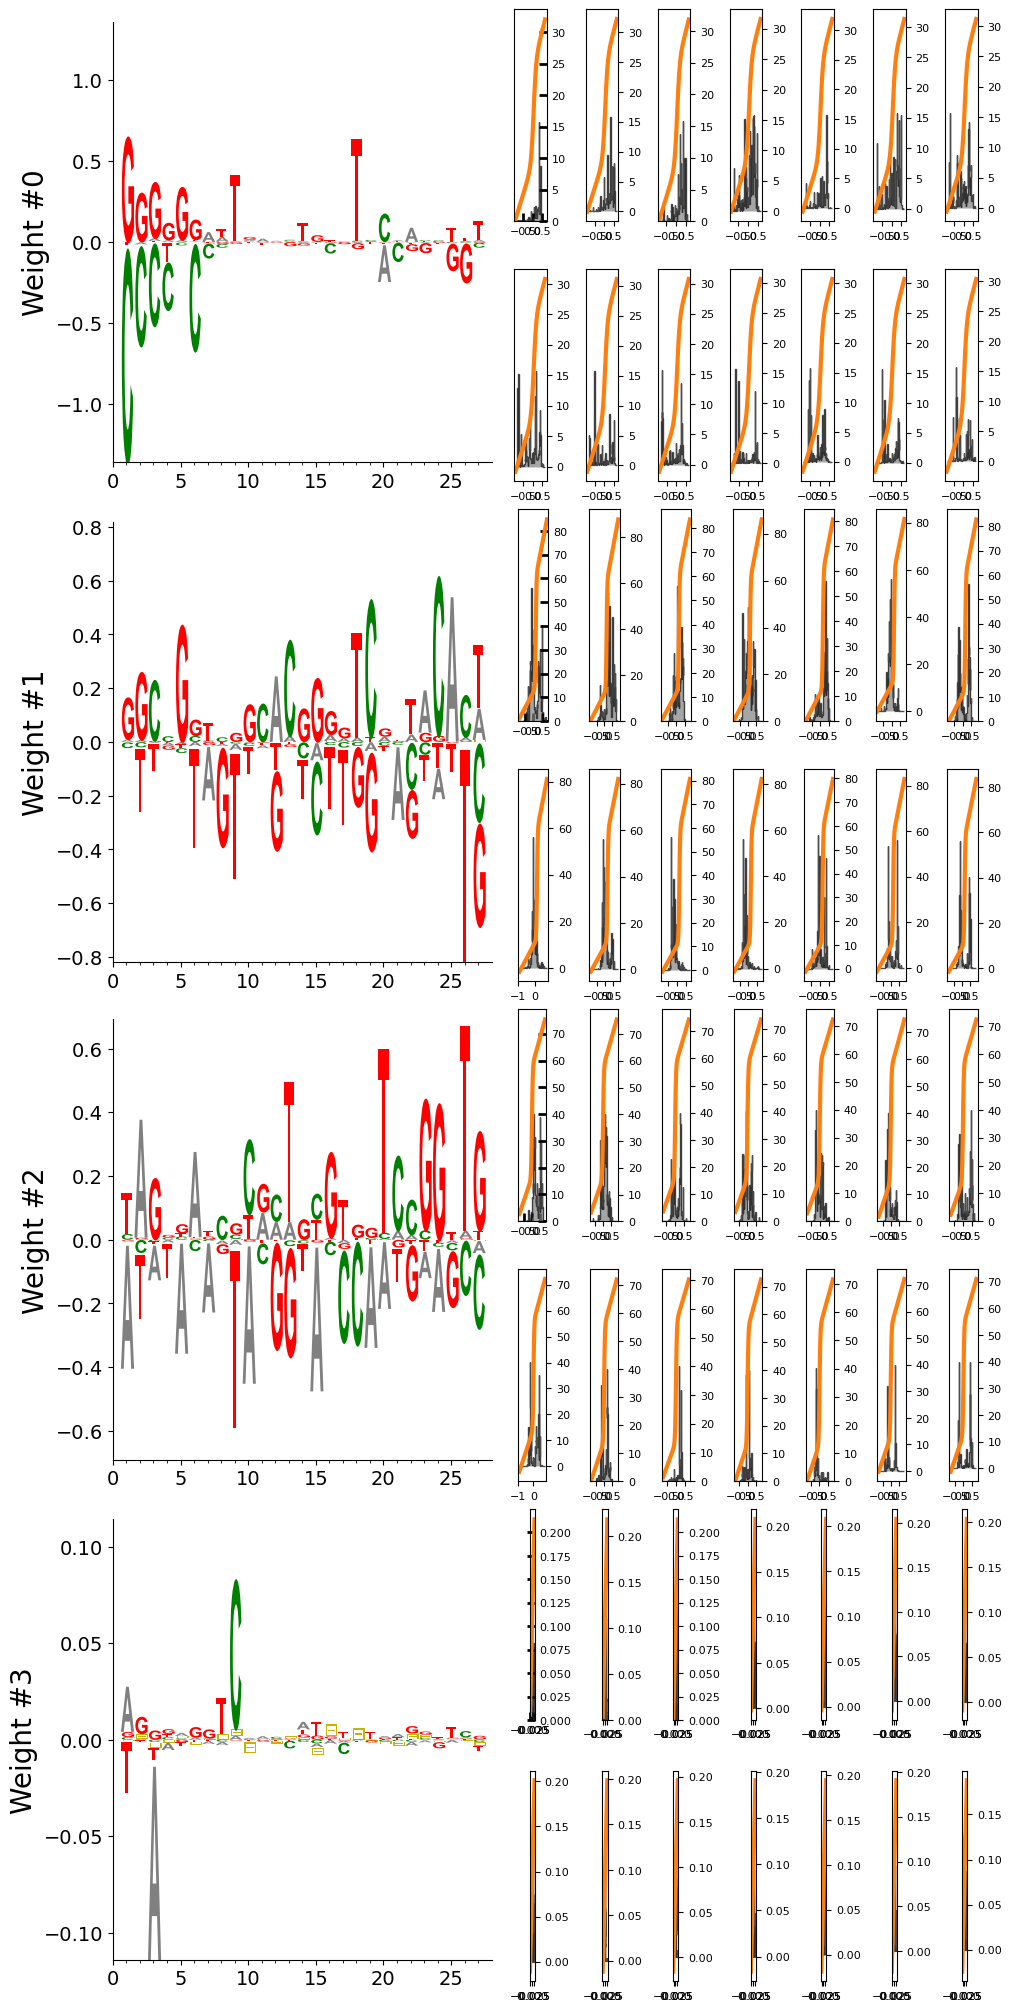

In [23]:
am_crbm.data_with_weights_plot(r9_crbm, all_data[all_data["round"] == "r9"], "hidden4", [0, 1, 2, 3], kdim="full", data="mean")

In [30]:
r9_likelihoods["likelihoods"]["r9"]

[1006.6652713425774,
 929.4501956722443,
 880.441741715973,
 1008.4001920829778,
 939.4348709180786,
 1036.364341973057,
 803.6816693160554,
 991.5154881126791,
 828.8718674217735,
 959.5997357213782,
 978.6806573443237,
 996.7222578620112,
 1043.9692647278616,
 871.3895026237869,
 816.2416109737887,
 1026.6593511687915,
 1001.3803547433054,
 1027.8716594040498,
 877.8504837172086,
 1048.8123355414928,
 1000.8553396578682,
 1016.3589155432064,
 834.8766545275266,
 915.2473638487654,
 944.1325345180976,
 846.5673505622299,
 906.1065648462627,
 945.6270381453432,
 993.415733420512,
 932.584552428706,
 819.4855691111434,
 992.1180602989925,
 877.1859500250102,
 1032.6756692880854,
 817.8305927011552,
 1005.9260937225745,
 1008.7746460715198,
 985.4697442760662,
 991.5827132382083,
 1031.012332164716,
 912.6566390039789,
 941.0684838227735,
 1005.7149791900492,
 951.2523718731527,
 1004.2850783842932,
 976.3235253770454,
 977.7876430676824,
 849.9708451063216,
 1003.2667399037027,
 1029.47

In [8]:
r9_data = all_data[all_data["round"] == "r9"].copy()
r9_data.reset_index(drop=True, inplace=True)
r9_data["likelihood"] = r9_likelihoods["likelihoods"]["r9"]
# print(r12_data)

In [33]:
r9_by_copynum = r9_data.sort_values("copynum", ascending=False)
r9_by_likeli = r9_data.sort_values("likelihood", ascending=False)

Clustering by Inputs on hidden nodes

In [11]:
import torch

def dataframe_to_input_crbm(dataframe, base_to_id, v_num, q, weights=False):
    seqs = dataframe["sequence"].tolist()
    oh_ten = torch.zeros((len(seqs), v_num, q), dtype=torch.long)
    for iid, seq in enumerate(seqs):
        for n, base in enumerate(seq):
            oh_ten[iid, n, base_to_id[base]] = 1
    if weights:
        weights = dataframe["copynum"].tolist()
        return oh_ten, weights
    else:
        return oh_ten

# Produces flat vector of Inputs of each hidden unit (reduced over the convolution dimension (k) by sum or mean)
def flatten_and_reduce_input(Ih, reduction="sum"):
     # Iuk (Batch, hidden number (u), conv number (k))
    if reduction == "sum":
        return torch.cat([Iuk.sum(2) for Iuk in Ih], 1)
    elif reduction == "mean":
        return torch.cat([Iuk.mean(2) for Iuk in Ih], 1)
    else:
        print(f"Reduction {reduction} not supported", file=sys.stderr)
        exit(-1)

def prepare_input_vector(crbm, dataframe):
    if type(dataframe) == pd.DataFrame:
        base_to_id = am.int_to_letter_dicts[crbm.molecule]
        data_tensor = dataframe_to_input_crbm(dataframe, base_to_id, crbm.v_num, crbm.q, weights=False)
    elif type(dataframe) == torch.Tensor:
        data_tensor = dataframe
    input_hiddens = crbm.compute_output_v(data_tensor) # List of Iuk matrices
    return flatten_and_reduce_input(input_hiddens).detach().numpy()

In [13]:
# Primary Component Analysis
from sklearn.decomposition import PCA
import clustering_methods as  cm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

r9_data = all_data[all_data["round"] == "r9"]
r9_input = prepare_input_vector(r9_crbm, r9_data)
scaler = StandardScaler()
input_r9_processed = scaler.fit_transform(r9_input)
X_r9 = input_r9_processed

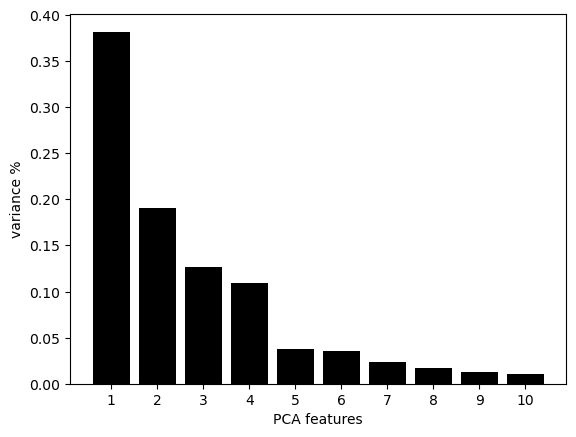

In [14]:
cm.pca_component_check(X_r9, components=10)

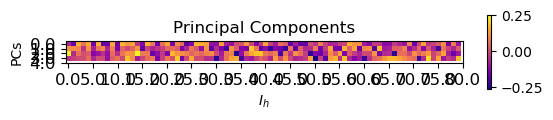

In [15]:
# We will do the first 4 components only, Drop in variance at feature 5

pca_r9 = PCA(n_components=4)
principal_components = pca_r9.fit_transform(X_r9)
PCA_components_pd_r9 = pd.DataFrame(principal_components)
components = pca_r9.components_
cm.view_components(components)


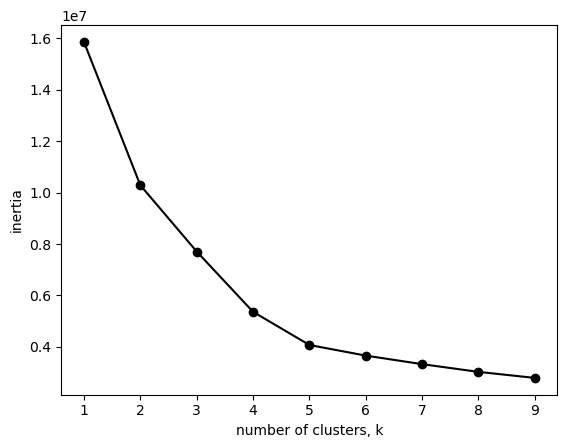

In [16]:
# KMeans on Transformed Sequences
from sklearn.cluster import KMeans

ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)

    # Fit model to samples
    model.fit(PCA_components_pd_r9.iloc[:, :4])

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [17]:
# Elbow Point is at 5 so we will run it for 5 clusters
kmeans_pca = KMeans(n_clusters=5, init="k-means++", random_state=38)
kmeans_pca.fit(principal_components)
# Add principal components to dataframe
df_pca_kmeans = pd.concat([r9_data.reset_index(drop=True), pd.DataFrame(principal_components)], axis=1)
df_pca_kmeans.columns.values[-4:] = ["Component 1", "Component 2", "Component 3", "Component 4"]
# Add labels from kmeans
df_pca_kmeans["K-mean PCA Label"] = kmeans_pca.labels_
# Replace integer with label in new column
df_pca_kmeans["Segment"] = df_pca_kmeans["K-mean PCA Label"].map({0:1, 1:2, 2:3, 3:4, 4:5})

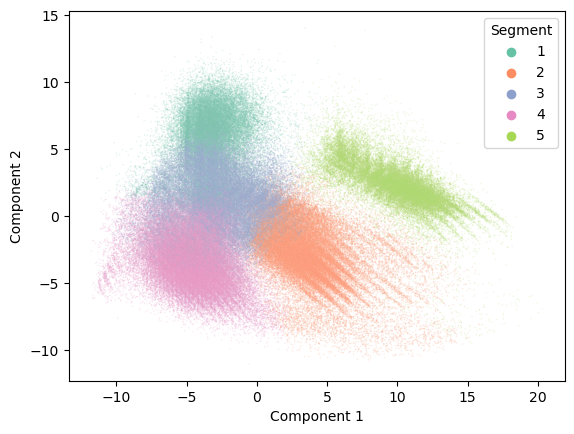

In [18]:
# colors = ['#747FE3', '#8EE35D', '#E37346']
sns.scatterplot(data=df_pca_kmeans, x="Component 1", y="Component 2", hue="Segment", alpha=0.2, s=1, palette="Set2")
plt.show()

Now we need to see what the primary components are learning

Let's try the same exact thing on round 2 now

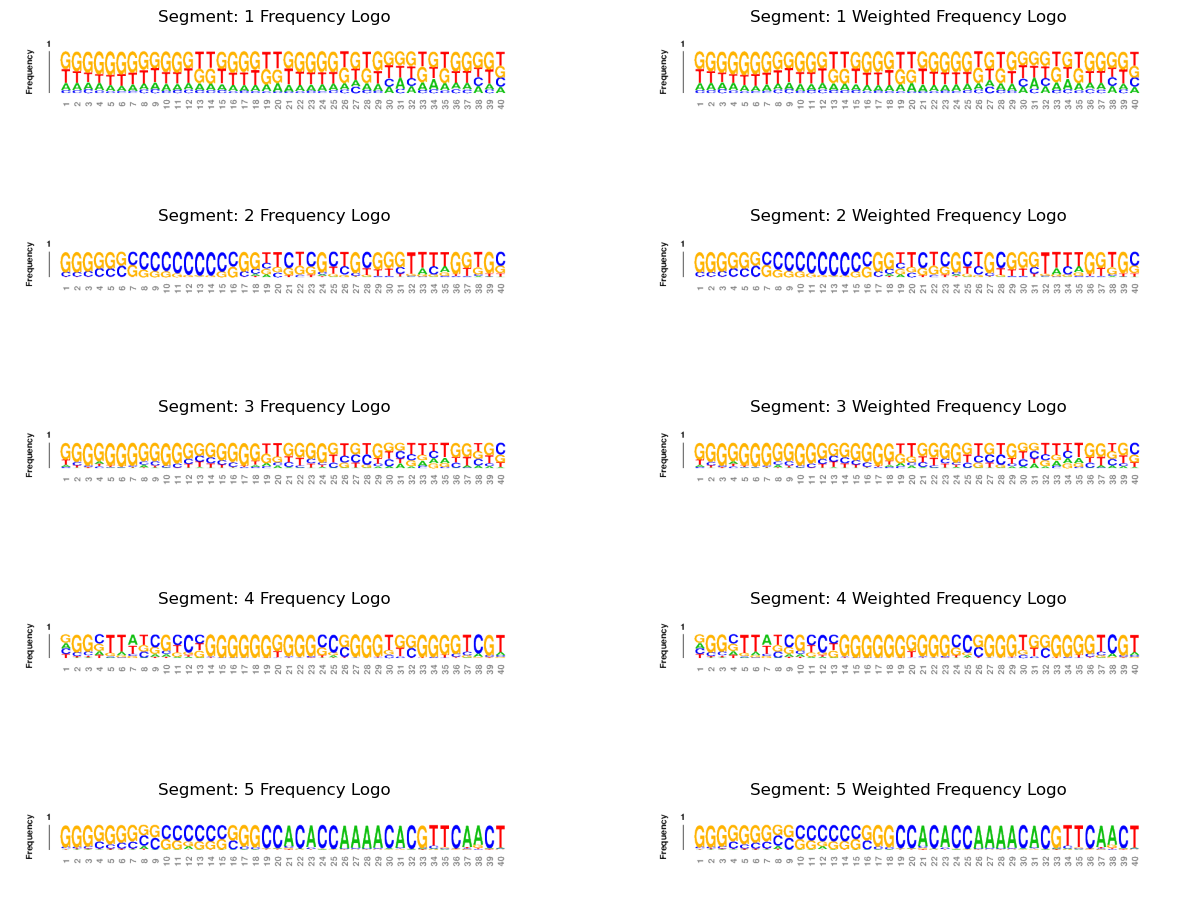

In [19]:
segments = [1, 2, 3, 4, 5]

# Generate Sequence Logo for Each Cluster
pca_paths_u, pca_paths_w = [], []
for seg in segments:
    pca_paths_u.append(am.seq_logo(df_pca_kmeans[df_pca_kmeans["Segment"] == seg], f"r9_pcak_sw_c{seg}_seqlogo", weight=False, outdir="./generated/"))
    pca_paths_w.append(am.seq_logo(df_pca_kmeans[df_pca_kmeans["Segment"] == seg], f"r9_pcak_sw_c{seg}_seqlogo", weight=True, outdir="./generated/"))


# Seq Logo showing Frequency of Each Amino Acid at each position
fig, axs = plt.subplots(len(segments), 2)
fig.set_size_inches(15, 12)

for rid, r in enumerate(segments):
    img1 = mpimg.imread(f"{pca_paths_u[rid]}.freq.png")
    img2 = mpimg.imread(f"{pca_paths_w[rid]}.freq.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"Segment: {r} Frequency Logo")
    axs[rid][1].set_title(f"Segment: {r} Weighted Frequency Logo")

plt.show()

In [22]:
segments = [1, 2, 3, 4, 5]
segments_negative = [f"{i}_neg" for i in segments]
segments_high = [f"{i}_high" for i in segments]
segments_low = [f"{i}_low" for i in segments]
# Plot Likelihood Curves of individual segments
df_pca_kmeans["likelihood"] = r9_likelihoods["likelihoods"]["r9"]
likelihood_dict = {}
for seg in segments:
    segment_subset = df_pca_kmeans[df_pca_kmeans["Segment"] == seg]
    segment_negative = segment_subset[segment_subset["assignment"] == "N"]
    segment_low = segment_subset[segment_subset["assignment"] == "L"]
    segment_high = segment_subset[segment_subset["assignment"] == "H"]
    likelihoods = segment_subset.likelihood.tolist()
    likelihoods_negative = segment_negative.likelihood.tolist()
    likelihoods_low = segment_low.likelihood.tolist()
    likelihoods_high = segment_high.likelihood.tolist()
    likelihood_dict[seg] = likelihoods
    likelihood_dict[f"{seg}_neg"] = likelihoods_negative
    likelihood_dict[f"{seg}_low"] = likelihoods_low
    likelihood_dict[f"{seg}_high"] = likelihoods_high

In [17]:
def plot_likelihoods_multiple(likeli,  order, labels, title=None, xaxislabel="log-likelihood", xlim=None, cdf=False, legend_font_size=10):
    colors = am.supported_colors
    plot_num = len(order)
    fig, axs = plt.subplots(plot_num, 1, sharex=True, sharey=False)
    for xid, x in enumerate(order): # each subplots likelihood dictionary labels
        if xlim is not None:
            axs[xid].set_xlim(*xlim)

        plot_ymax = 0.
        for yid, y in enumerate(x): # each label in the subplot labels
            z = sns.kdeplot(likeli[y], shade=False, alpha=0.5, color=colors[yid], ax=axs[xid], label=labels[xid][yid], cumulative=cdf)
            kdeplot = axs[xid].lines[-1]
            ydata = kdeplot.get_ydata()
            ymax = round(ydata.max(), 3)
            if ymax > plot_ymax:
                plot_ymax = ymax

        if xid == len(order) - 1:
            z.set(xlabel=xaxislabel)
        # axs[xid].legend()
        axs[xid].legend(loc=2, prop={'size': legend_font_size})
        axs[xid].tick_params(axis='x', labelsize=12)
        axs[xid].tick_params(axis='y', labelsize=8)
        axs[xid].set_yticks([0., plot_ymax])
    if title:
        fig.suptitle(title)
    else:
        fig.suptitle("Log-Likelihood Gaussian KDE Curve of Likelihoods by Dataset")
    plt.show()

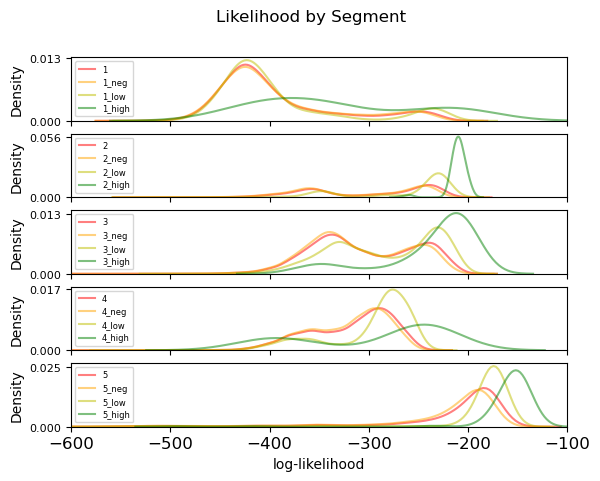

In [26]:
seg_list = [segments, segments_negative, segments_low, segments_high]
seg_list_t = [list(x) for x in zip(*seg_list)]
am.plot_likelihoods_multiple(likelihood_dict, seg_list_t, seg_list_t, title="Likelihood by Segment", xlim=(-600, -100), legend_font_size=6)

In [25]:
seg1 = df_pca_kmeans[df_pca_kmeans["Segment"] == 5].sort_values("likelihood", axis=0, ascending=False)
seg1.head(20)

,sequence,copynum,round,assignment,Component 1,Component 2,Component 3,Component 4,K-mean PCA Label,Segment,likelihood
1238,GGGGGGGCCCCCCCCGGGCCACACCAAAACACGTTCAACT,9.606294,r9,H,12.072990,1.486801,-2.798757,1.254209,4,5,-133.433544
213676,GGGGGGGGGCCCCCCGGGCCACACCAAAACACGTTCAACT,9.851246,r9,H,10.777747,2.301370,-3.796439,-0.434002,4,5,-133.632497
209810,GGGGGGGCGCCCCCCGGGCCACACCAAAACACGTTCAACT,8.441607,r9,H,11.410854,1.812854,-3.331981,0.383111,4,5,-134.484931
222684,GGGGGGGGCCCCCCCGGGCCACACCAAAACACGTTCAACT,9.463276,r9,H,11.439882,1.975317,-3.263214,0.437096,4,5,-134.940722
128871,GGGGGGGGGCCCCCCCGGCCACACCAAAACACGTTCAACT,8.771681,r9,H,11.806540,2.289997,-3.373791,-0.150691,4,5,-135.002031
130564,GGGGGGCCCCCCCCCGGGCCACACCAAAACACGTTCAACT,8.489000,r9,H,12.734203,1.034034,-2.268494,1.940121,4,5,-137.015271
199432,GGGGGGGCGCCCCCCCGGCCACACCAAAACACGTTCAACT,7.710206,r9,H,12.439648,1.801482,-2.909333,0.666422,4,5,-137.139326
235096,GGGGGGGCCCCCCCCCGGCCACACCAAAACACGTTCAACT,9.212139,r9,H,13.101783,1.475429,-2.376109,1.537520,4,5,-137.599337
152795,GGGGGGGGCCCCCCCCGGCCACACCAAAACACGTTCAACT,8.728426,r9,H,12.468676,1.963944,-2.840566,0.720406,4,5,-138.241780
53531,GGGGGCGCCCCCCCCGGGCCACACCAAAACACGTTCAACT,7.608871,r9,H,12.515493,1.111456,-2.390422,1.889095,4,5,-139.690444


In [27]:
seg2 = df_pca_kmeans[df_pca_kmeans["Segment"] == 4].sort_values("likelihood", axis=0, ascending=False)
seg2.head(20)

,sequence,copynum,round,assignment,Component 1,Component 2,Component 3,Component 4,K-mean PCA Label,Segment,likelihood
91176,GGGCTTATCGTCAGGGGGGGGGGTCCGGGTTCGGGGTCGT,5.030122e-09,r9,N,-4.204208,-1.919137,-0.990369,2.346430,3,4,-229.981414
53356,GGGCTTATCGTCAGGGGGGTGGGTCCGGGTTCGGGGTCGT,5.924258e+00,r9,H,-4.020973,-0.956709,0.193331,2.811370,3,4,-230.837019
101642,GGGCTTATCGTCCGGGGGGGGGGTCCGGGTTCGGGGTCGT,1.431664e-04,r9,L,-3.844948,-2.814331,-0.416740,2.164740,3,4,-232.274520
108785,AGGCTTATCGTCAGGGGGGGGGGTCCGGGTTCGGGGTCGT,5.609458e-03,r9,L,-4.225531,-1.863269,-1.013648,2.504961,3,4,-232.658465
130566,GGGGTTATCGTCCGGGGGGGGGGTCCGGGTTCGGGGTCGT,5.030122e-09,r9,N,-4.104023,-2.488658,-0.650217,1.682150,3,4,-233.238950
197469,GGGCTTATCGTCCGGGGGGTGGGTCCGGGTTCGGGGTCGT,3.345908e-04,r9,L,-3.661713,-1.851902,0.766960,2.629680,3,4,-233.291793
15127,AGGCTTATCGTCAGGGGGGTGGGTCCGGGTTCGGGGTCGT,1.124376e+01,r9,H,-4.042297,-0.900840,0.170051,2.969901,3,4,-233.670406
74661,TGGCTTATCGTCAGGGGGGGGGGTCCGGGTTCGGGGTCGT,3.547885e-05,r9,L,-4.214699,-1.905620,-0.964706,2.584266,3,4,-233.888753
166836,GGGCTTATCGCCCGGGGGGGGGGTCCGGGTTCGGGGTCGT,5.030122e-09,r9,N,-2.914339,-3.887952,-0.587328,1.325755,3,4,-233.917068
144030,CGGCTTATCGTCAGGGGGGTGGGTCCGGGTTCGGGGTCGT,6.180019e+00,r9,H,-3.950445,-1.033329,0.214093,3.010025,3,4,-234.508256


In [28]:
seg3 = df_pca_kmeans[df_pca_kmeans["Segment"] == 3].sort_values("copynum", axis=0, ascending=False)
seg3.head(20)

,sequence,copynum,round,assignment,Component 1,Component 2,Component 3,Component 4,K-mean PCA Label,Segment,likelihood
104334,GGGAGGGAGGGTGGGGGGTTCTCGCTGCGGGTTTTGGTGC,12.720894,r9,H,-4.114733,0.556873,1.490589,-3.389562,2,3,-198.044100
64687,TCGCGGGGGGCGGGTCGGGTGCTCGTTCGAGGGGTCACAG,9.545669,r9,H,-1.775822,0.394195,-0.941114,-3.085137,2,3,-261.144401
237642,TCGGGGGGCGGGCTGGGTCAGGGGTCCCACTACGGCATGC,9.492130,r9,H,1.107607,2.149982,-2.893917,-3.045921,2,3,-273.249689
200688,TGGGTGGGAGGGAGGGGGGCTTTATTCCGGTGTTTTTTCG,9.428592,r9,H,-2.542264,4.022465,1.943521,-4.910611,2,3,-293.712172
30335,TCGCGGGGGGCGGGTCGGGTGCTCGTTCGAGGGGTCGCAG,9.285819,r9,H,-2.162562,-0.171982,-0.971869,-2.988683,2,3,-251.751539
244332,GGGGGGGGGGGGTTGGGGTTGGGGGTCTGCACTATGGCTC,9.110299,r9,H,-5.057888,3.588772,-0.835309,-4.626303,2,3,-189.528362
232131,GGGGGGGGGGGGTTGGGGTAGGGGGTCTGCACTATGGCTC,8.765147,r9,H,-4.209707,3.619799,-2.222335,-4.322928,2,3,-188.391460
195226,TCTGGGGGTGGCGGTTGGGCTACGCTGCGTTGCGCTTGCT,8.713746,r9,H,-1.261033,1.738533,0.228076,-1.632251,2,3,-368.520929
61988,GGGGGGGGGGGGTTGGGGTATGGGGTCTGCACTATGGCTC,8.609225,r9,H,-4.076197,4.459140,-1.042350,-3.960792,2,3,-193.617688
55905,ACCTGGGGGGTGGGACGGGATGGGGTCGTGGTGTTGGCCT,8.551208,r9,H,-4.833800,0.865178,-1.512948,-1.870228,2,3,-351.727010


In [29]:
seg4 = df_pca_kmeans[df_pca_kmeans["Segment"] == 2].sort_values("likelihood", axis=0, ascending=False)
seg4.head(20)

,sequence,copynum,round,assignment,Component 1,Component 2,Component 3,Component 4,K-mean PCA Label,Segment,likelihood
189736,GGGGGGCCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC,9.150909,r9,H,4.305825,-3.263906,5.962941,-0.205350,1,2,-197.371536
179187,GGGGGGGCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC,10.315630,r9,H,3.644611,-2.811139,5.432678,-0.891262,1,2,-197.625727
225628,GGGGGGCCCCCCCCCGGGTTCTCGCTGCGGGTTTTGGTGC,8.132413,r9,H,3.277032,-3.252533,5.540293,-0.488661,1,2,-198.248547
76772,GGGGGGGCGCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC,8.858653,r9,H,2.982476,-2.485086,4.899454,-1.762360,1,2,-198.512415
88164,GGGGGGGCCCCCCCCGGGTTCTCGCTGCGGGTTTTGGTGC,8.852522,r9,H,2.615818,-2.799766,5.010030,-1.174573,1,2,-198.912855
36470,GGGGGCCCCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC,8.912204,r9,H,4.748329,-3.639251,6.371276,0.429536,1,2,-199.527728
122651,GGGGGGGGGCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC,10.394947,r9,H,2.349368,-1.996570,4.434997,-2.579473,1,2,-199.612972
242386,GGGGGGCCGCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC,6.594415,r9,H,3.643690,-2.937853,5.429717,-1.076448,1,2,-199.676126
236625,GGGGGCCCCCCCCCCGGGTTCTCGCTGCGGGTTTTGGTGC,8.167352,r9,H,3.719535,-3.627878,5.948628,0.146226,1,2,-200.397881
177277,GGGGGGGGCCCCCCCCGGTTCTCGCTGCGGGTTTTGGTGC,10.021448,r9,H,3.011504,-2.322623,4.968221,-1.708375,1,2,-202.045492


In [30]:
seg5 = df_pca_kmeans[df_pca_kmeans["Segment"] == 1].sort_values("likelihood", axis=0, ascending=False)
seg5.head(20)

,sequence,copynum,round,assignment,Component 1,Component 2,Component 3,Component 4,K-mean PCA Label,Segment,likelihood
227622,GGGGGGGGTGGGTTTGGGTATGGGGTCTGCACTATGGCTC,6.257670e+00,r9,H,-4.043186,6.009337,0.529087,-1.685804,0,1,-204.068254
72867,TGGGGGGGTGGGTTTGGGTATGGGGTCTGCACTATGGCTC,7.177783e+00,r9,H,-4.053678,6.022855,0.554749,-1.447968,0,1,-204.354222
160381,CGGGGGGGTGGGTTTGGGTATGGGGTCTGCACTATGGCTC,2.057142e-02,r9,L,-3.972658,5.932716,0.549849,-1.487149,0,1,-205.009229
233770,GGGGGGGGTGGGTTTGGGTTTGGGGTCTGCACTATGGCTC,1.414871e+00,r9,L,-4.891367,5.978311,1.916113,-1.989179,0,1,-206.422907
91696,AGGGGGGGTGGGTTTGGGTATGGGGTCTGCACTATGGCTC,8.997066e-03,r9,L,-4.064510,6.065205,0.505808,-1.527273,0,1,-206.810748
219602,TGGGGGGGTGGGTTTGGGTTTGGGGTCTGCACTATGGCTC,6.028281e+00,r9,H,-4.901859,5.991829,1.941775,-1.751343,0,1,-206.934372
193630,CGGGGGGGTGGGTTTGGGTTTGGGGTCTGCACTATGGCTC,3.436843e-03,r9,L,-4.820839,5.901690,1.936875,-1.790524,0,1,-207.492367
67111,AGGGGGGGTGGGTTTGGGTTTGGGGTCTGCACTATGGCTC,5.030122e-09,r9,N,-4.912691,6.034179,1.892834,-1.830648,0,1,-209.281945
75786,GGGGGGGGGGGTTTTGGGTATGGGGTCTGCACTATGGCTC,2.146081e-01,r9,L,-4.001946,6.326691,0.890675,-1.909435,0,1,-210.344448
238459,TGGGGGGGTGGGTTTGGGTATGGGGTCTGCACTATGGCTA,5.030122e-09,r9,N,-4.093383,6.102375,0.571886,-1.438073,0,1,-212.194234


In [ ]:
utils.cat_to_seq

In [54]:
seqs, hiddens = utils.gen_data_lowT(r9_crbm, beta=2, which = 'marginal' ,Nchains=100, Lchains=500, Nthermalize=200, Nstep=2, N_PT=5, reshape=True, update_betas=False)
seqs_zero, hiddens_zero = utils.gen_data_zeroT(r9_crbm, which = 'marginal' ,Nchains=50, Lchains=500, Nthermalize=100, Nstep=2, N_PT=1, reshape=True, update_betas=False)

In [12]:
def prep_gen_seqs_pd(crbm, seqs):
    gen_data = seqs.detach()
    input_gen = prepare_input_vector(crbm, gen_data)
    X_gen = scaler.transform(input_gen)
    pca_generated = pca_r3.transform(X_gen)
    clusters_gen = kmeans_pca.predict(pca_generated)
    gen_seqs = utils.cat_to_seq(gen_data.argmax(-1).detach().numpy(), molecule=crbm.molecule)
    gen_seqs_input_pd = pd.DataFrame({"sequence": gen_seqs, "round":clusters_gen})
    _, gen_likelihoods = crbm.predict(gen_seqs_input_pd)
    gen_seqs_input_pd["likelihood"] = gen_likelihoods
    return gen_seqs_input_pd

In [13]:
zeroT_pd = prep_gen_seqs_pd(r3_crbm, seqs_zero)
lowT_pd = prep_gen_seqs_pd(r3_crbm, seqs)

In [ ]:
gen_data = seqs.detach()
input_gen = prepare_input_vector(r3_crbm, gen_data)
X_gen = scaler.transform(input_gen)
pca_generated = pca_r3.transform(X_gen)
clusters_gen = kmeans_pca.predict(pca_generated)
gen_seqs = utils.cat_to_seq(gen_data.argmax(-1).detach().numpy(), molecule=r3_crbm.molecule)
gen_seqs_input_pd = pd.DataFrame({"sequence": gen_seqs, "round":clusters_gen})
_, gen_likelihoods = r3_crbm.predict(gen_seqs_input_pd)
gen_seqs_input_pd["likelihood"] = gen_likelihoods

In [14]:
# Plot Likelihoods as kde curves with each round in a new row
def plot_likelihoods_pd(likelihood_pd, columnkey, keys, labels, title=None, xaxislabel="log-likelihood", xlim=None, cdf=False):
    colors = am.supported_colors
    plot_num = len(keys)
    fig, axs = plt.subplots(plot_num, 1, sharex=True, sharey=False)
    for xid, x in enumerate(keys):
        if xlim is not None:
            axs[xid].set_xlim(*xlim)
        y = sns.kdeplot(likelihood_pd[likelihood_pd[columnkey] == x].likelihood.tolist(), shade=False, alpha=0.5, color=colors[xid], ax=axs[xid], label=labels[xid], cumulative=cdf)
        if xid == len(keys) - 1:
            y.set(xlabel=xaxislabel)
        axs[xid].legend()
    if title:
        fig.suptitle(title)
    else:
        fig.suptitle("Log-Likelihood Gaussian KDE Curve of Likelihoods by Dataset")
    plt.show()

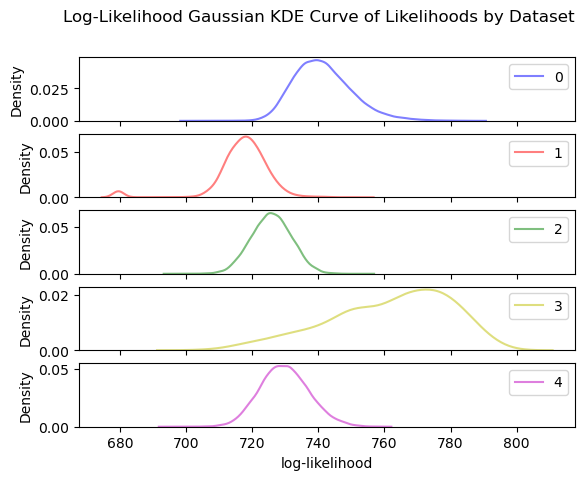

In [15]:
plot_likelihoods_pd(lowT_pd, "round", [0, 1, 2, 3, 4], [0, 1, 2, 3, 4])

No handles with labels found to put in legend.
No handles with labels found to put in legend.


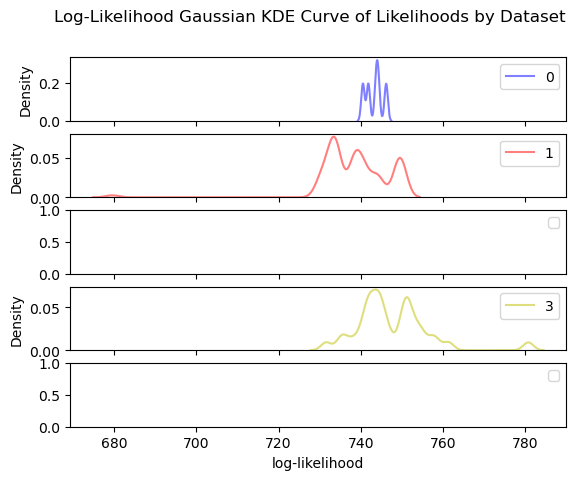

In [16]:
plot_likelihoods_pd(zeroT_pd, "round", [0, 1, 2, 3, 4], [0, 1, 2, 3, 4])

In [26]:
lowT_pd[lowT_pd["round"] == 4].sort_values("likelihood", ascending=False).head(200)

,sequence,round,likelihood
36575,GGTAGTGGTTTGGTTGGGGGGGTTTGTTAGGTGTTTGTGG,4,758.865555
20491,GGGTTGTGGGTTAGGGGGGGTTTAGGTAGTTTAGGTATGG,4,758.480590
32492,AGGGGTTGGGGGGGGTTTGTTTAGGTTTATGGGTTGGTCA,4,757.815208
14075,GTGGGTTTTAGGGGGGGGGGAGTGTTTGGTTTTTTGTTTA,4,757.770517
16533,AGGGGGTGGGGTTGTAGGGGTTTATGGTTTGGTTTGGTTG,4,757.315495
...,...,...,...
39287,GGGTGTAGGCTGTGGGTGTAGTTGGTTAGGTTTAGGTCCT,4,747.538344
5842,GGCGCAGGGGGTGGGGGGTTTTATGTTTCGTTGGTTAATG,4,747.532260
4903,GGTGGGAGTGGGGGTTGTTGGGTGTGTATTTCGTTGTTCG,4,747.502695
36600,GGGGGGGGGTTGACTTATGTTTTGGGTTGGGGACTTGGTG,4,747.493904


In [19]:
zeroT_pd[zeroT_pd["round"] == 1].sort_values("likelihood", ascending=False).head(200)

,sequence,round,likelihood
2500,CCCCCCGCCCGCGCGGCGGCGGCGGGGTAGATGTTTTTGG,0,746.197406
2829,CCCCCCGCCCGCGCGGCGGCGGCGGGGTAGATGTTTTTGG,0,746.197406
2842,CCCCCCGCCCGCGCGGCGGCGGCGGGGTAGATGTTTTTGG,0,746.197406
2841,CCCCCCGCCCGCGCGGCGGCGGCGGGGTAGATGTTTTTGG,0,746.197406
2840,CCCCCCGCCCGCGCGGCGGCGGCGGGGTAGATGTTTTTGG,0,746.197406
...,...,...,...
2900,CCCCCCGCCCGCGCGGCGGCGGCGGGGTAGATGTTTTTGG,0,746.197406
2899,CCCCCCGCCCGCGCGGCGGCGGCGGGGTAGATGTTTTTGG,0,746.197406
2898,CCCCCCGCCCGCGCGGCGGCGGCGGGGTAGATGTTTTTGG,0,746.197406
2897,CCCCCCGCCCGCGCGGCGGCGGCGGGGTAGATGTTTTTGG,0,746.197406


In [24]:
from functools import reduce

r11_data = all_data[all_data["round"] == "r11"]

def get_common_vals(pd1, pd2, key):
    """Takes two pandas dataframes, and return list of shared values in each dataframe column specified by optional parameter key"""
    return list(reduce(set.intersection, map(set, [pd1[key], pd2[key]])))

common_seqs_r3_r11 = get_common_vals(r11_data, r3_data, "sequence")
common_seqs_lowT_r11 = get_common_vals(r11_data, lowT_pd, "sequence")
common_seqs_zeroT_r11 = get_common_vals(r11_data, zeroT_pd, "sequence")
common_seqs_zeroT_r3 = get_common_vals(r3_data, zeroT_pd, "sequence")
common_seqs_lowT_r3 = get_common_vals(r3_data, lowT_pd, "sequence")


print(len(common_seqs_zeroT_r11), len(common_seqs_lowT_r11), len(common_seqs_zeroT_r3), len(common_seqs_lowT_r3))

0 0 0 0


In [89]:
3

250000

In [82]:
r11_data.shape[0]

301571

In [90]:
print(len(common_seqs_lowT))
print(len(common_seqs_zeroT))

0
0


In [ ]:
segments = [1, 2, 3, 4, 5]
# Plot Likelihood Curves of individual segments
df_pca_kmeans["likelihood_r11"] = r3_likelihoods["likelihoods"]["r11"]
likelihood_dict = {}
for seg in segments:
    segment_subset = df_pca_kmeans[df_pca_kmeans["Segment"] == seg]
    likelihoods = segment_subset.likelihood.tolist()
    likelihood_dict[seg] = likelihoods


am.plot_likelihoods(likelihood_dict, segments, segments, title="Likelihood by Segment", xlim=(670, 820))

In [67]:
seqs, hiddens = utils.gen_data_lowT(r12_crbm, beta=1, which = 'marginal' ,Nchains=20, Lchains=500, Nthermalize=0, Nstep=1, N_PT=1, reshape=True, update_betas=False)

In [68]:
gen_data_pd = seqs.detach()
input_gen = prepare_input_vector(r12_crbm, gen_data_pd)
X_gen = scaler.transform(input_gen)
pca_generated = pca.transform(X_gen)
clusters_gen = kmeans_pca.predict(pca_generated)

In [69]:
def cat_to_seq(categorical_tensor):
    cat_ten = categorical_tensor.numpy()
    int_to_base = {0: 'A', 1: 'C', 2: 'G', 3: 'T', 4: '-'}
    seqs = []
    for i in range(categorical_tensor.shape[0]):
        seq = ""
        for j in range(categorical_tensor.shape[1]):
            seq += int_to_base[cat_ten[i][j]]
        seqs.append(seq)
    return seqs

gen_seqs = cat_to_seq(gen_data_pd.argmax(-1))

In [70]:
gen_seqs_input_pd = pd.DataFrame({"sequence": gen_seqs, "round":clusters_gen})
gen_likelihoods = r12_crbm.predict(gen_seqs_input_pd)

In [71]:
gen_full_pd = gen_seqs_input_pd
gen_full_pd["likelihood"] = gen_likelihoods[1]

gen_likelihood_dict = {}
clusters = np.arange(1, 8)
for cluster in clusters:
    cluster_subset = gen_full_pd[gen_full_pd["round"] == cluster]
    likelihoods = cluster_subset.likelihood.tolist()
    gen_likelihood_dict[cluster] = likelihoods

No handles with labels found to put in legend.
No handles with labels found to put in legend.


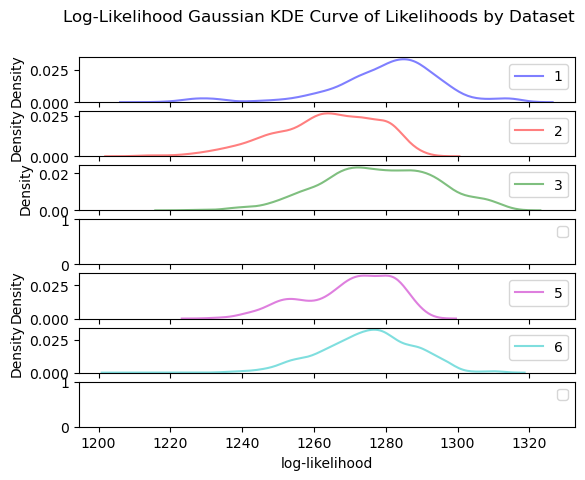

In [72]:
am.plot_likelihoods(gen_likelihood_dict, clusters, clusters)

In [87]:
# Let's classify each of the experimental sequences in a cluster
exp_seqs = {
    "SP5_sup": 'ACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT',
    "SP5_pap": '-ACCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTTG',
    "SP6": "CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGGCTTGGT",
    "SP7_sup": "CGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGGGT",
    "SP7_pap": "-AGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGAT",
    "SP6C": 'CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGGCTTGGT',
    "SP634":  "CCCATGGTAGGTATTGCTTGGTAGGGATAGTGGG------",
    "SP634G": "CCCATGGTAGGTATTGGTTGGTAGGGATAGTGGG------",
    "SP634C": "CCCATGGTAGGTATTGCTTGGTAGCGATAGTGGG------",
    "SP634A": "CCCATGGTAGGTATTGCATGGTAGGGATAGTGGG------",
    "SP630":  "---CATGGTAGGTATTGCATGGTAGGGATAGTG-------",
    "SP619":  "------------TATTGCATGGTAGGGATAG---------",
}

keys = exp_seqs.keys()
values = exp_seqs.values()
new_exp_seqs = {}
set_nuc = "A"
for i in keys:
    seq = exp_seqs[i]
    while "-" in seq:
        # new_char = np.random.choice(["A", "C", "G", "T"])
        new_char = set_nuc
        ind = seq.find("-")
        seq = seq[:ind] + new_char + seq[ind+1:]
    new_exp_seqs[i] = seq

rand_exp_seqs = new_exp_seqs
rand_exp_set = {'id':list(new_exp_seqs.keys()), 'sequence':list(new_exp_seqs.values())}
rand_exp_pd = pd.DataFrame(rand_exp_set)

In [88]:
input_exp = prepare_input_vector(r12_crbm, rand_exp_pd)
X_exp = scaler.transform(input_exp)
pca_exp = pca.transform(X_exp)
clusters_exp = kmeans_pca.predict(pca_exp)
_, exp_r12_likelihoods = r12_crbm.predict(rand_exp_pd)
print(clusters_exp)

[5 5 5 5 5 5 5 5 5 0]


SP5 1278.2952021701003
SP6 1277.5987851952877
SP7 1273.983184315899
SP6C 1272.2539308398236
SP634 1250.1074460143745
SP634G 1248.1686831422721
SP634C 1242.1351936718138
SP634A 1238.205802402089
SP630 1241.8425745136055
SP619 1240.9896687986911


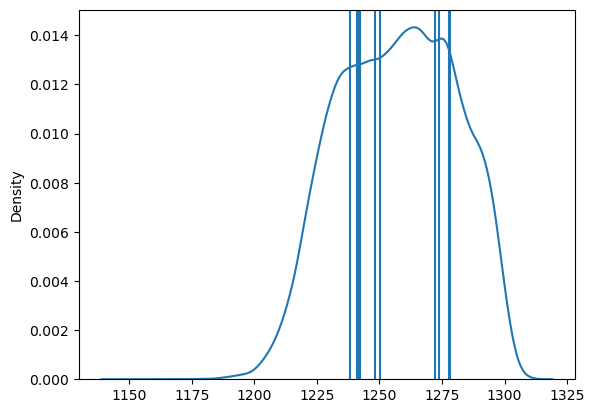

In [89]:
fig, axs = plt.subplots(1, 1)
sns.kdeplot(x=likelihood_dict["6"])


for iid, i in enumerate(new_exp_seqs.keys()):
    print(i, exp_r12_likelihoods[iid])
    plt.axvline(exp_r12_likelihoods[iid])

plt.show()

In [91]:
r12_pd = all_data[all_data["round"] == "r12"] # r12_data
r12_pd["cluster"] = df_pca_kmeans["Segment"].tolist()
r12_pd["likelihood"] = r12_likelihoods["likelihoods"]["r12"]

r12_c6_pd = r12_pd[r12_pd["cluster"] == "6"]

r12_highest = r12_c6_pd[r12_c6_pd["likelihood"] > 1285]
r12_mid = r12_c6_pd[r12_c6_pd["likelihood"] > 1250]

<ipython-input-91-1cdc2f7d2c30>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r12_pd["cluster"] = df_pca_kmeans["Segment"].tolist()
<ipython-input-91-1cdc2f7d2c30>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r12_pd["likelihood"] = r12_likelihoods["likelihoods"]["r12"]


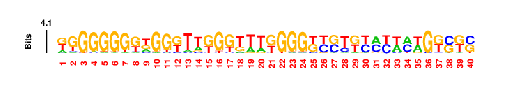

In [93]:
sl = am.seq_logo(r12_highest, "r12_c6_high_likeli", weight=False, outdir="./generated/")
fig, axs = plt.subplots(1, 1)
am.seqlogo_subplot(axs, sl, type="info")
plt.show()

In [98]:
r12_c6_pd.head()

,sequence,copynum,round,assignment,cluster,likelihood
5,ATAATGTTAACAATGGGGGGTGGGAAGGGTAGGGGGTCGT,1.0,r12,L,6,1256.347018
16,CTATGGTAGGTATTGCTTGGTAGGGATAGTGGGTTTGCTG,1.0,r12,L,6,1259.633689
26,CTGGGGGGTGGGTCTGGGTATGGGGTCTGCACTATAGCTC,1.0,r12,L,6,1271.011836
37,CCCATGTATGTTATTGATTGTTTGGATTTGTGGGCTTGAT,1.0,r12,L,6,1243.485433
62,AAGGAGGGTAGGTAGTGCTCGGTAGGGAAACTCTGCCGAT,1.0,r12,L,6,1262.474035


In [100]:
r12_c6_pd_by_copynum = r12_c6_pd.sort_values("copynum", axis=0, ascending=False)
r12_c6_pd_by_copynum.head()

,sequence,copynum,round,assignment,cluster,likelihood
175772,AGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGATT,650339.0,r12,H,6,1290.505682
137124,AAGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGCCGAT,445204.0,r12,H,6,1290.425812
404130,AGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGTCGATT,75423.0,r12,H,6,1286.164744
354587,AAGGAGGGTAGGTAGTGCTTGGTAGGGAAACTCCGTCGAT,50745.0,r12,H,6,1284.713516
83248,CACGTTGTACACTGGGGGGTGGGAAGGGCTGGGTCCAGAT,20817.0,r12,H,6,1236.024896


In [102]:
r12_c6_pd_by_likelihood = r12_c6_pd.sort_values("likelihood", axis=0, ascending=False)
r12_c6_pd_by_likelihood.head(20)

,sequence,copynum,round,assignment,cluster,likelihood
469351,AGGCTTATCGTCAGGGGGGTGGTTCCGGTTTTGGGGTCGT,3.0,r12,L,6,1311.647367
401986,TTGGGGGGTGGGTTGGTTTTTGGGTCGTTTCTACAGTGGG,1.0,r12,L,6,1310.213880
447627,GGGGGGGGGGGGTTGGGTTTTGGGTTCTGCACTATGGCTC,2.0,r12,L,6,1310.170770
81619,AGGCTTATCGTCAGGGGGATGGGTTCGGGTTTGGGGTCGT,1.0,r12,L,6,1310.131038
516505,TGGGGGGGGGGGTTGGGTTTTGGGTTCTGCACTATGGCTC,1.0,r12,L,6,1309.958333
299840,TGGGGGGTGGGTTTTGTTTTGGGGCTCCGCACTATGGCTC,1.0,r12,L,6,1309.945164
488396,GGGGGGGGGGTTTTGGTTAGGGGGTCGTTTCTACAGTGGG,1.0,r12,L,6,1309.818671
287880,TTGGGGGGAGGGTAGGGTTTTGGGTCGTTTCTACAGTGGG,1.0,r12,L,6,1309.294048
223447,GGGGGGGGTGGTTTGGTTTGGGGGTCGTTTCTACAGTGGG,2.0,r12,L,6,1309.162330
65221,GGGGGGGTAGGGTAGGTTATTGGGTCGTTTCTACAGTGGG,1.0,r12,L,6,1309.152644


In [ ]:
# import scipy
#
# def monoExp(x, m, t, b):
#     return m * np.exp(-t * x) + b
#
# p0 = (2000, .1, 50) # start with values near those we expect
# params, cv = scipy.optimize.curve_fit(monoExp, xs, ys, p0)
# m, t, b = params

In [103]:
def log(x):
    return math.log(x+0.0001)

r12_c6_pd["log_copynum"] = r12_c6_pd["copynum"].map(log)

<ipython-input-103-42975cf7f062>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r12_c6_pd["log_copynum"] = r12_c6_pd["copynum"].map(log)


In [106]:
r12_c6_pd.sort_values("log_copynum", axis=0, ascending=True).head()

,sequence,copynum,round,assignment,cluster,likelihood,log_copynum
5,ATAATGTTAACAATGGGGGGTGGGAAGGGTAGGGGGTCGT,1.0,r12,L,6,1256.347018,0.0001
412344,GGGGGGGTTGGGTTTGGTTTTGGGTTCTGCACTATGGCTC,1.0,r12,L,6,1303.069770,0.0001
412361,GTAGGTGAGTAGGTGCTTTTAGGTGTTAGTGATAGGACTA,1.0,r12,L,6,1218.722540,0.0001
412363,GGGGGGGGTGGGTTGTTTTTGGGGTCGTTTCTACAGTGGG,1.0,r12,L,6,1302.419006,0.0001
412365,TCGGGGGGTGGGCTTGGGTATAGGGTCTGCACTATGGCTC,1.0,r12,L,6,1284.631532,0.0001


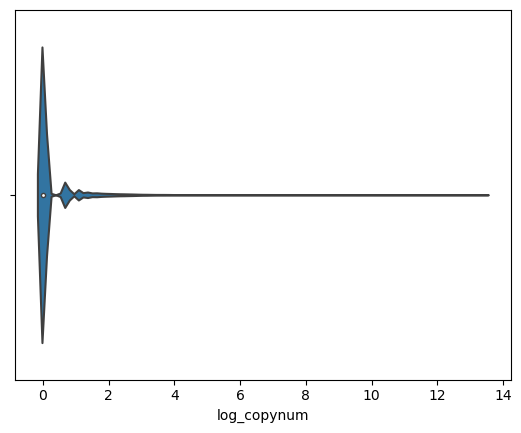

In [107]:
sns.violinplot(data=r12_c6_pd, x="log_copynum")
plt.show()

In [108]:
r12_c6_pd["log_copynum"].sum()

18114.26577846481

In [46]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS

cluster_method = "db"
if cluster_method == "db":
    alg = DBSCAN(eps=1.8, metric='euclidean', min_samples=5000).fit(input_processed)
    core_samples_mask = np.zeros_like(alg.labels_, dtype=bool)
    core_samples_mask[alg.core_sample_indices_] = True

elif cluster_method == "op":
    alg = OPTICS(min_samples=2000, metric="euclidean").fit(input_processed)
    # core_distance_mask = np.zeros_like(alg.labels_, dtype=bool)
    # core_samples_mask[alg.core_sample_indices_] = True


labels = alg.labels_

In [48]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
cluster_id = set(labels)
for clust in cluster_id:
    print('Clust', clust, 'Length', list(labels).count(clust))

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Clust 0 Length 64206
Clust 1 Length 29728
Clust 2 Length 217801
Clust 3 Length 72241
Clust 4 Length 66688
Clust 5 Length 25061
Clust 6 Length 4459
Clust 7 Length 11366
Clust 8 Length 8262
Clust 9 Length 8348
Clust 10 Length 9604
Clust 11 Length 2128
Clust 12 Length 2212
Clust 13 Length 1143
Clust -1 Length 127694
Estimated number of clusters: 14
Estimated number of noise points: 127694


In [ ]:
# Now we should try to visualize each clusters sequence logo

r12_db_data = r12_data
r12_db_data["cluster"] = list(labels)

# Generate Sequence Logo for Each Cluster
db_paths_u, db_paths_w = [], []
for clust in cluster_id:
    db_paths_u.append(am.seq_logo(r12_db_data[r12_db_data["cluster"] == clust], f"db_c{clust}_seqlogo", weight=False, outdir="./generated/"))
    db_paths_w.append(am.seq_logo(r12_db_data[r12_db_data["cluster"] == clust], f"db_c{clust}_seqlogo", weight=True, outdir="./generated/"))


# Seq Logo showing Frequency of Each Amino Acid at each position
fig, axs = plt.subplots(len(rounds), 2)
fig.set_size_inches(15, 12)

for rid, r in enumerate(rounds):
    img1 = mpimg.imread(f"{db_paths_u[rid]}.freq.png")
    img2 = mpimg.imread(f"{db_paths_w[rid]}.freq.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"{r} Frequency Logo")
    axs[rid][1].set_title(f"{r} Weighted Frequency Logo")

plt.show()



In [27]:
# Elbow Point is at 4 so we will run it for 4 clusters
kmeans_pca = KMeans(n_clusters=7, init="k-means++", random_state=38)
kmeans_pca.fit(principal_components_4)
# Add principal components to dataframe
df_pca_kmeans = pd.concat([r12_data.reset_index(drop=True), pd.DataFrame(principal_components_4)], axis=1)
df_pca_kmeans.columns.values[-4:] = ["Component 1", "Component 2", "Component 3", "Component 4"]
# Add labels from kmeans
df_pca_kmeans["K-mean PCA Label"] = kmeans_pca.labels_
# Replace integer with label in new column
df_pca_kmeans["Segment"] = df_pca_kmeans["K-mean PCA Label"].map({0:'first', 1:'second', 2:"third", 3:'fourth', 4:'fifth', 5:"sixth", 6:"seventh", 7:"eighth"})

/home/jonah/anaconda3/envs/utils/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


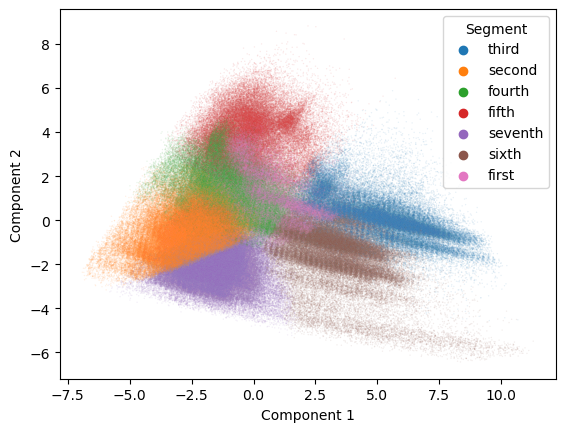

In [28]:
sns.scatterplot(data=df_pca_kmeans, x="Component 1", y="Component 2", hue="Segment", alpha=0.1, s=1)
plt.show()

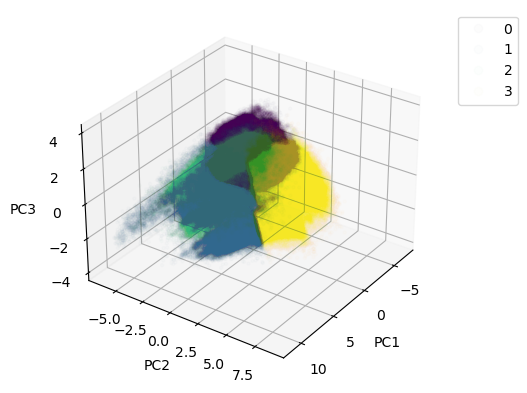

In [39]:
fig = plt.figure()
ax = plt.axes(projection='3d')
sc = ax.scatter(df_pca_kmeans["Component 1"], df_pca_kmeans["Component 2"], df_pca_kmeans["Component 3"], c=df_pca_kmeans["K-mean PCA Label"], alpha=0.01, marker=".")
ax.view_init(30, 35)  # Set viewing angle
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

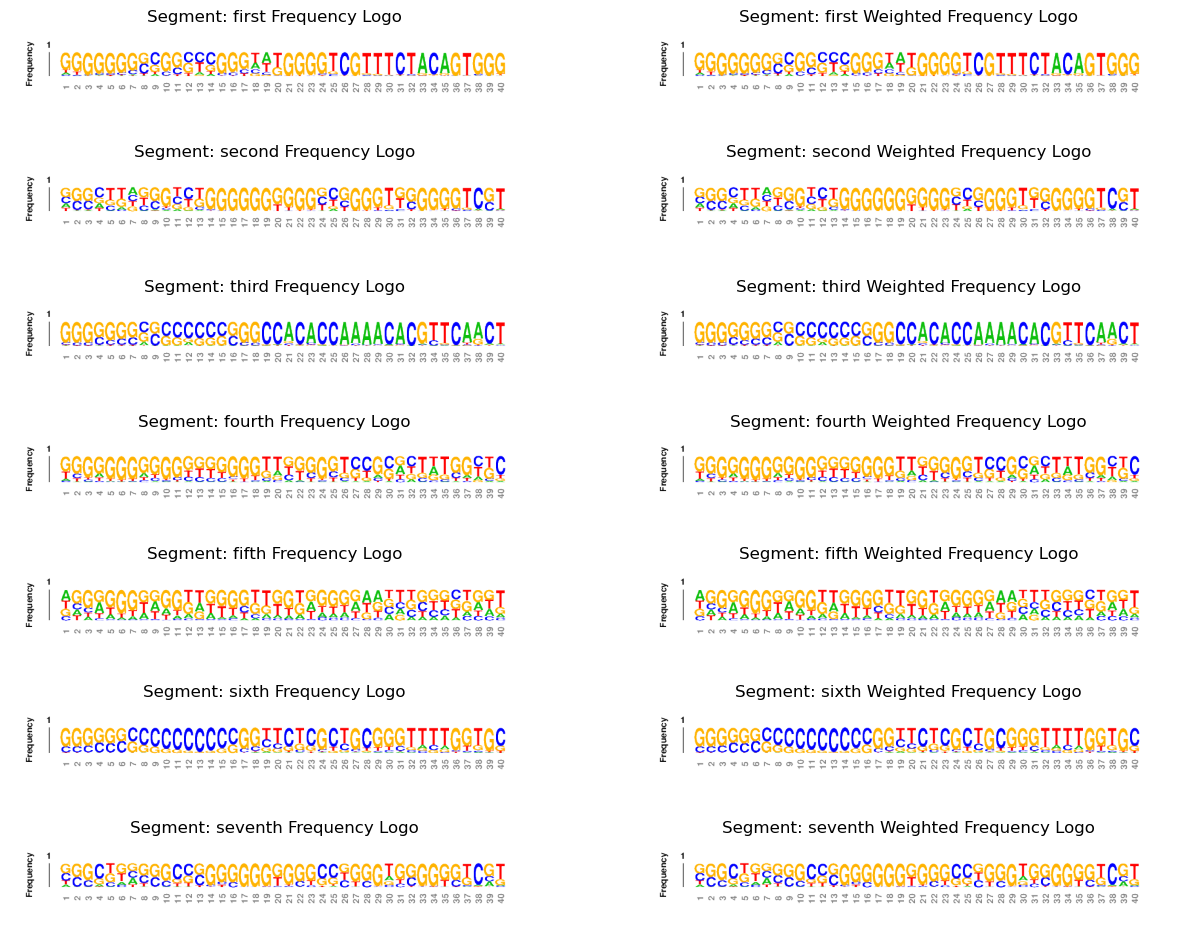

In [30]:
segments = ["first", "second", "third", "fourth", "fifth", "sixth", "seventh"]

# Generate Sequence Logo for Each Cluster
pca_paths_u, pca_paths_w = [], []
for seg in segments:
    pca_paths_u.append(am.seq_logo(df_pca_kmeans[df_pca_kmeans["Segment"] == seg], f"db_c{seg}_seqlogo", weight=False, outdir="./generated/"))
    pca_paths_w.append(am.seq_logo(df_pca_kmeans[df_pca_kmeans["Segment"] == seg], f"db_c{seg}_seqlogo", weight=True, outdir="./generated/"))


# Seq Logo showing Frequency of Each Amino Acid at each position
fig, axs = plt.subplots(len(segments), 2)
fig.set_size_inches(15, 12)

for rid, r in enumerate(segments):
    img1 = mpimg.imread(f"{pca_paths_u[rid]}.freq.png")
    img2 = mpimg.imread(f"{pca_paths_w[rid]}.freq.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"Segment: {r} Frequency Logo")
    axs[rid][1].set_title(f"Segment: {r} Weighted Frequency Logo")

plt.show()

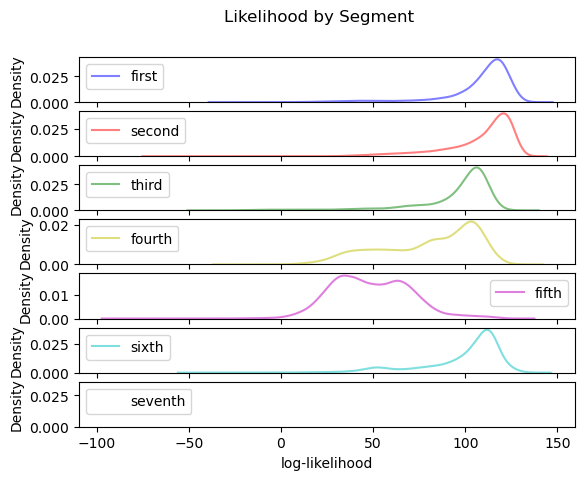

In [39]:
segments = ["first", "second", "third", "fourth", "fifth", "sixth", "seventh"]
# Plot Likelihood Curves of individual segments
df_pca_kmeans["likelihood"] = r12_likelihoods["likelihoods"]["r12"]
likelihood_dict = {}
for seg in segments:
    segment_subset = df_pca_kmeans[df_pca_kmeans["Segment"] == seg]
    likelihoods = segment_subset.likelihood.tolist()
    likelihood_dict[seg] = likelihoods


am.plot_likelihoods(likelihood_dict, segments, segments, title="Likelihood by Segment", xlim=None)

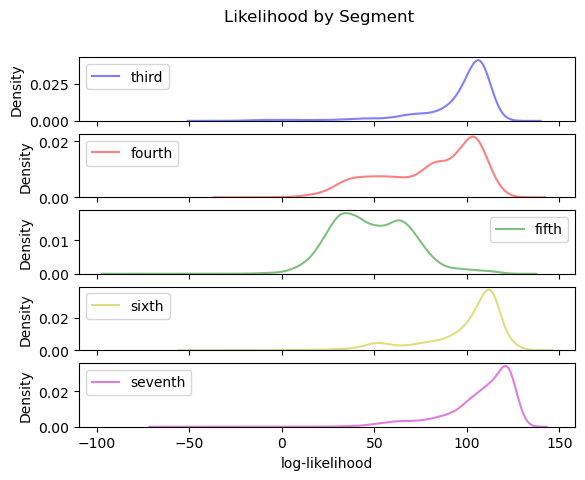

In [40]:
am.plot_likelihoods(likelihood_dict, segments[-5:], segments[-5:], title="Likelihood by Segment", xlim=None)

In [ ]:
am.plot_likelihoods(r12_likelihoods["likelihoods"], segments, segments, title=None, xaxislabel="log-likelihood", xlim=None, cdf=False)